In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
# Load MNIST Data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root='./data', train=True, transform=trans, download=True) 
test_set = dset.MNIST(root='./data', train=False, transform=trans)
batch_size = 32


train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)

In [4]:
# Model AlexNet
class AlexNet(nn.Module):   
    def __init__(self, num=10):
        super(AlexNet, self).__init__()

        self.layer1 =nn.Sequential (
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True))
        self.layer2 =nn.Sequential (            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),   
            nn.MaxPool2d( kernel_size=2, stride=2))
        self.layer3 =nn.Sequential (
            
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))                         
        self.layer4 =nn.Sequential (

            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))                         
        self.layer5 =nn.Sequential (

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1)
        )

        
#        self.classifier = nn.Sequential(
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(32*12*12, 2048),
            nn.ReLU())
            
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.ReLU())        
        self.fc2 = nn.Sequential(
            nn.Linear(1024,num)
        )
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out    
    # def forward(self, x):

    #     x = self.feature(x)
    #     x = x.view(-1,32*12*12)
    #     x = self.classifier(x)
    #     return x
    

In [5]:
model = AlexNet()
if torch.cuda.is_available():
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01) # Setting optimizer
train_losses = []
test_losses =[]
test_accuracy = []

In [ ]:
def train(epoch): # train phase
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
#         loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target) #loss is cross_entropy
        train_losses.append(loss.item()) 
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('\rEpoch: {} {:.0f}%\t     Loss: {:.6f}'.format(
                epoch,
                100. * batch_idx / len(train_loader), loss.item()), end='')

In [7]:
def test(): # inference phase
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc1=100. * float(correct.to(torch.device('cpu')).numpy())
    print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
        test_loss, acc1 / len(test_loader.dataset)))
    
    test_accuracy.append(acc1 / len(test_loader.dataset))

In [8]:

for epoch in range(1, 10):#range(1,15)   do training
    train(epoch)
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc1=100. * float(correct.to(torch.device('cpu')).numpy())
    print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
        test_loss, acc1 / len(test_loader.dataset)))
    
    test_accuracy.append(acc1 / len(test_loader.dataset))
plt.figure()
plt.plot(train_losses)
plt.title('train losses')
plt.xlabel('step')
plt.ylabel('percent')

plt.figure()
plt.plot(test_losses)
plt.title('test losses')
plt.xlabel('step')
plt.ylabel('percent')

plt.figure()
plt.plot(test_accuracy)
plt.title('test_accuracy')
plt.xlabel('step')
plt.ylabel('percent')
    

Epoch: 1 96%	     Loss: 2.296321

C:\Users\bon\AppData\Local\Temp\ipykernel_24056\934638893.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
c:\Users\bon\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test result: Average loss: 2.3002, Accuracy: 11.3500%

Epoch: 2 96%	     Loss: 2.283369
Test result: Average loss: 2.2798, Accuracy: 12.7400%

Epoch: 3 96%	     Loss: 0.109435
Test result: Average loss: 0.1119, Accuracy: 96.2700%

Epoch: 4 96%	     Loss: 0.068640
Test result: Average loss: 0.0612, Accuracy: 97.9100%

Epoch: 5 96%	     Loss: 0.057011
Test result: Average loss: 0.0523, Accuracy: 98.2200%

Epoch: 6 96%	     Loss: 0.003946
Test result: Average loss: 0.0402, Accuracy: 98.6100%

Epoch: 7 96%	     Loss: 0.049715
Test result: Average loss: 0.0353, Accuracy: 98.7400%

Epoch: 8 96%	     Loss: 0.039235
Test result: Average loss: 0.0318, Accuracy: 98.9500%

Epoch: 9 96%	     Loss: 0.036357
Test result: Average loss: 0.0299, Accuracy: 98.9500%



Text(0, 0.5, 'percent')

: 

: 

In [ ]:
sh = (list(enumerate(model.modules()))[0][1].fc1[1]).weight.shape # sh = weight of shape which located in fc1[1]

v = []
with torch.no_grad():
    
    for i in range(sh[0]): # copy tensors
        for j in range(sh[1]):
            v.append([i, j, (list(enumerate(model.modules()))[0][1].fc1[1]).weight[i, j].item()])
        if i % 100 == 0:
            print(i)

0
100
200
300
400
500
600
700
800
900
1000


In [ ]:
 # check default(Fault Free) Accuracy
test_loss = 0
correct = 0
for data, target in test_loader:
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
        
    
test_loss /= len(test_loader.dataset)
test_losses.append(test_loss)
acc=100. * float(correct.to(torch.device('cpu')).numpy())
print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
    test_loss, acc / len(test_loader.dataset)))
    
test_accuracy.append(acc / len(test_loader.dataset))

/tmp/ipykernel_2017117/1431447092.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test result: Average loss: 0.0321, Accuracy: 98.9300%



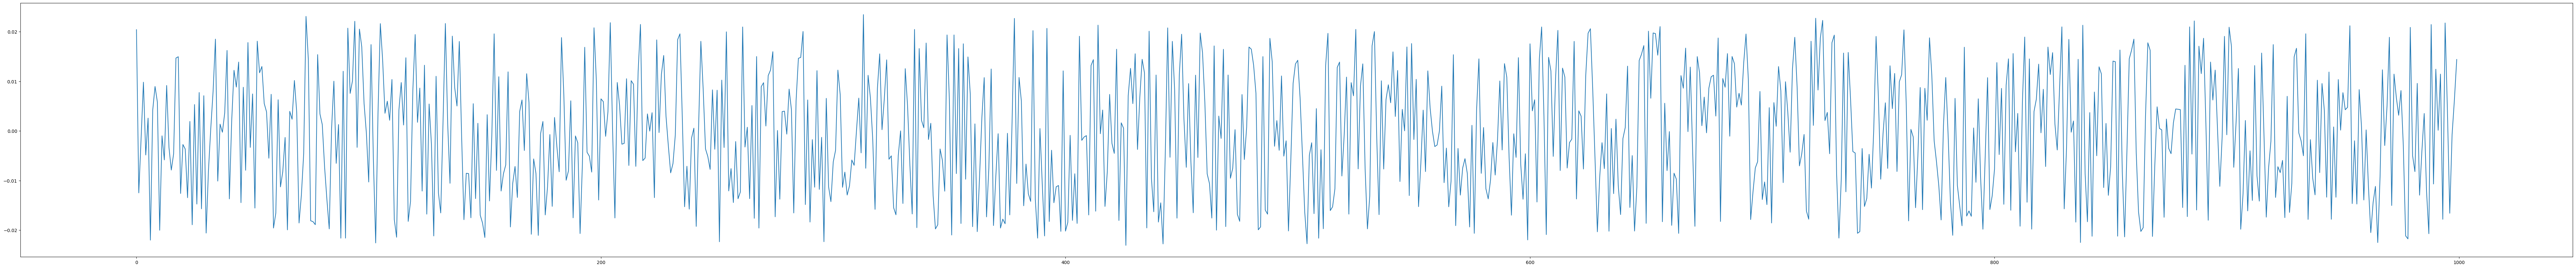

In [ ]:
# Check graph of weights
from matplotlib import pyplot as plt 
plt.figure(figsize=(100,10))
plt.plot(list(zip(*v[:10000:10]))[2])

In [ ]:
correct_hist = []
sh = (list(enumerate(model.modules()))[0][1].fc1[1]).weight.shape
layer = (list(enumerate(model.modules()))[0][1].fc1[1]).weight
#num=int(4098*4098*(1/20))
num = 10
temp = 0
r = 0
n=10
with open("C:\바탕 화면\실험\alexnet실험.txt", 'w') as f:
    for a in range(1): # total run NUM
        with torch.no_grad():
            test_loss = 0
            correct = 0
            test_losses=[]
            test_accuracy=[]
            r = random.randrange(0,num) 
            temp = layer[v[r][0]][v[r][1]].clone() #copy the default value
            layer[v[r][0]][v[r][1]] = 10**random.randrange(3, 10)#*random.randrange(10,20) insert random weight value in random neruon which located in specific layer(fc1)           
            print("Fault injected: {:4d} {:4d} {:.5f}=>{:.5f}".format(v[r][0], v[r][1], v[r][2], layer[v[r][0]][v[r][1]].item()))
            print("Fault injected: {:4d} {:4d} {:.5f}=>{:.5f}".format(v[r][0], v[r][1], v[r][2], layer[v[r][0]][v[r][1]].item()), file=f)
            
            for data, target in test_loader: # do test with fault
                if torch.cuda.is_available():
                    data, target = data.cuda(), target.cuda()
                    data, target = Variable(data, volatile=True), Variable(target)
                    output = model(data)
                    test_loss += F.cross_entropy(output, target, size_average=False).item()
                    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                    correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
                
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            acc=100. * float(correct.to(torch.device('cpu')).numpy())
            print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
                test_loss, acc / len(test_loader.dataset)))
            print('Fault Injected Test result: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(
                test_loss, acc / len(test_loader.dataset)), file=f)
                
        for i in range(n): # Top n Neurons
            with torch.no_grad():
                # print(layer[v[i][0]][v[i][1]])
                test_loss = 0
                correct = 0
                test_losses=[]
                test_accuracy=[]
                target_temp = layer[v[i][0]][v[i][1]].clone() # save fault value at target_temp 
                print(layer[v[i][0]][v[i][1]])
    #            value=target.item() #save before value
                value=0
                layer[v[i][0]][v[i][1]] = 0 # change faulted value as 0   
                for data, target in test_loader:
                    data, target = Variable(data, volatile=True), Variable(target)
                    if torch.cuda.is_available():
                        data, target = data.cuda(), target.cuda()
                        data, target = Variable(data, volatile=True), Variable(target)
                        output = model(data)
                        test_loss += F.cross_entropy(output, target, size_average=False).item()
                        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
                        
                    
                test_loss /= len(test_loader.dataset)
                test_losses.append(test_loss)
                acc=100. * float(correct.to(torch.device('cpu')).numpy())
                print('{:4f} {:4f} Test result: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(
                    a, i, test_loss, acc / len(test_loader.dataset)), file=f)
                print('{:4f} {:4f} Test result: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(
                    a, i, test_loss, acc / len(test_loader.dataset)))

                test_accuracy.append(acc  / len(test_loader.dataset))
                correct_hist.append((i, j, correct, value))  # the highest value and weight changed to 0 가장 높은 확률과, 0으로 바뀐 weight까지            
                    
                layer[v[i][0]][v[i][1]] = target_temp  # insert faulted value a gain 
                if len(correct_hist) % 10 == 0:# check progress
                        print(correct_hist)
        with torch.no_grad():
            layer[v[r][0]][v[r][1]]=temp                #insert DEFAULT value a gain
        correct_hist = sorted(correct_hist, key = lambda x : abs(x[2]))  #sorting
        node_high = correct_hist[-1] # take index's max -> location, highest correct's time 
        node_low = correct_hist[0]
        print('{} when high: {}'.format(a, node_high))
        print('{} when high: {}'.format(a, node_high),file=f)

        print('{} when low: {}'.format(a, node_low))
        print('{} when low: {}'.format(a, node_low),file=f)
        print('{} accuracy of the high network on the test images: {}'.format(a, node_high[2]/len(test_loader.dataset)*100))
        print('{} accuracy of the high network on the test images: {}'.format(a, node_high[2]/len(test_loader.dataset)*100),file=f)
        print('{} accuracy of the low network on the test images'.format(a, node_low[2]/len(test_loader.dataset)*100))
        print('{} accuracy of the low network on the test images'.format(a, node_low[2]/len(test_loader.dataset)*100),file=f)
        correct_hist = []

Fault injected:    0    3 -0.01565=>100000.00000


/tmp/ipykernel_2017117/2893135251.py:24: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test result: Average loss: 2657.6077, Accuracy: 61.7100%

tensor(0.0204, device='cuda:0', requires_grad=True)


/tmp/ipykernel_2017117/2893135251.py:51: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/tmp/ipykernel_2017117/2893135251.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)


0.000000 0.000000 Test result: Average loss: 2657.6076, Accuracy: 61.7100%
tensor(-0.0104, device='cuda:0', requires_grad=True)
0.000000 1.000000 Test result: Average loss: 2657.6077, Accuracy: 61.7100%
tensor(-0.0218, device='cuda:0', requires_grad=True)
0.000000 2.000000 Test result: Average loss: 2657.6078, Accuracy: 61.7100%
tensor(100000., device='cuda:0', requires_grad=True)
0.000000 3.000000 Test result: Average loss: 0.0321, Accuracy: 98.9300%
tensor(0.0199, device='cuda:0', requires_grad=True)
0.000000 4.000000 Test result: Average loss: 2657.6075, Accuracy: 61.7100%
tensor(-0.0077, device='cuda:0', requires_grad=True)
0.000000 5.000000 Test result: Average loss: 2657.6078, Accuracy: 61.7100%
tensor(-0.0131, device='cuda:0', requires_grad=True)
0.000000 6.000000 Test result: Average loss: 2657.6079, Accuracy: 61.7100%
tensor(0.0082, device='cuda:0', requires_grad=True)
0.000000 7.000000 Test result: Average loss: 2657.6077, Accuracy: 61.7100%
tensor(-0.0189, device='cuda:0', r

In [ ]:
import platform
info = platform.uname()
print(info)
print(info.processor)
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

# check computer specification

uname_result(system='Linux', node='user-System-Product-Name', release='5.15.0-43-generic', version='#46~20.04.1-Ubuntu SMP Thu Jul 14 15:20:17 UTC 2022', machine='x86_64', processor='x86_64')
x86_64
True
4
NVIDIA GeForce RTX 3090
